In [1]:
import tensorflow as tf

# Path to the dataset
path_to_cards = "CardDataset"

In [2]:
# GPU check

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))
print("CUDA version:", tf.sysconfig.get_build_info().get('cuda_version'))
print("cuDNN version:", tf.sysconfig.get_build_info().get('cudnn_version'))

TensorFlow version: 2.10.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
CUDA version: 64_112
cuDNN version: 64_8


In [3]:
# Check if TensorFlow is using GPU
print("Is TensorFlow using GPU?", tf.test.is_built_with_cuda())
print("GPU Device Name:", tf.config.list_physical_devices('GPU'))

# Create a simple tensor operation
a = tf.constant([[1.0, 2.0, 3.0]])
b = tf.constant([[4.0, 5.0, 6.0]])
c = tf.matmul(a, b, transpose_b=True)
print(c)

Is TensorFlow using GPU? True
GPU Device Name: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
tf.Tensor([[32.]], shape=(1, 1), dtype=float32)


In [4]:
SIZE = 224
BATCH_SIZE = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path_to_cards + "/train",
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=(SIZE, SIZE),
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path_to_cards + "/test",
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=(SIZE, SIZE),
)

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path_to_cards + "/valid",
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=(SIZE, SIZE),
)

Found 7624 files belonging to 53 classes.
Found 265 files belonging to 53 classes.
Found 265 files belonging to 53 classes.


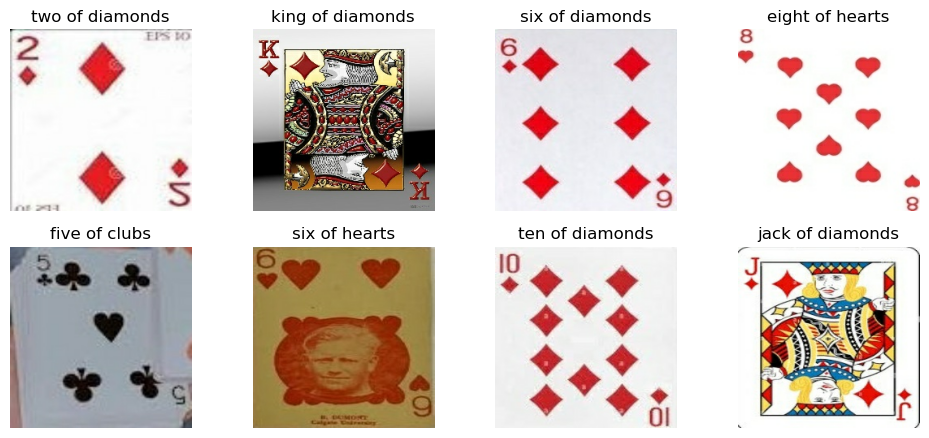

(32, 224, 224, 3)


In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Visualising a few samples.
images, labels = next(iter(train_ds.take(1)))

plt.figure(figsize=(12, 8))
for i in range(8):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[np.argmax(labels[i])])
    plt.axis("off")
plt.show()

print(images.shape)  # Output: [32, 112, 112, 3]

In [6]:
# Down sampling function
def downsample_image(images, size):
    return tf.image.resize(images, [size, size], method="bilinear")  # Only resizing images

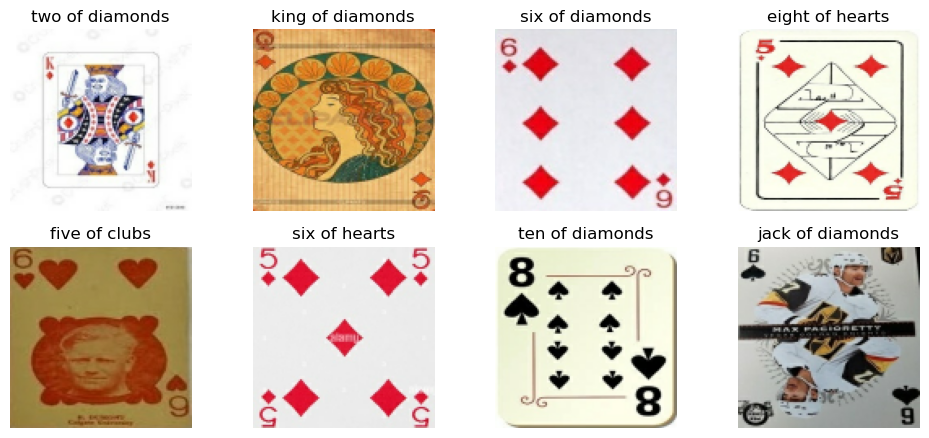

(32, 112, 112, 3)


In [7]:
# Visualizing down sampling (112 x 112)

images, _ = next(iter(train_ds.take(1)))
images_112 = downsample_image(images, 112)

# Get class names
class_names = train_ds.class_names

# Plot images
plt.figure(figsize=(12, 8))
for i in range(8):
    ax = plt.subplot(3, 4, i + 1)
    image = images_112[i].numpy().astype("uint8")
    plt.imshow(images_112[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")
plt.show()

print(images_112.shape)

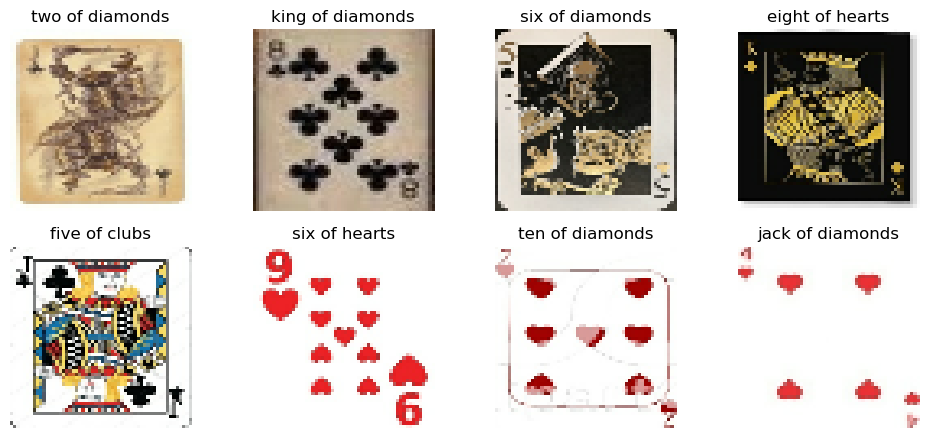

(32, 56, 56, 3)


In [8]:
# We don't think this is advisable, but let's take a look at image size of 56x56

images, _ = next(iter(train_ds.take(1)))
images_56 = downsample_image(images, 56)

# Get class names
class_names = train_ds.class_names

# Plot images
plt.figure(figsize=(12, 8))
for i in range(8):
    ax = plt.subplot(3, 4, i + 1)
    image = images_56[i].numpy().astype("uint8")
    plt.imshow(images_56[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")
plt.show()

print(images_56.shape)

# Not advisable, images loose a lot of quality. We need for quality images for input,
#  especially being that we want to capture details such as edges, curves and corners.
#  At 56 x56, you start to loose the different between hearts and diamonds, and
#  clubs and spades. So we stick with downsample size of 112.

# We are down sampling the images to 112 x 112 to reduce the computational complexity of the model.

In [9]:
# Proceed with applying down sampling

# 112 x 112 down sampling function for the dataset
def downsample_image(img, label, size=112):
    img = tf.image.resize(img, [size, size], method="bilinear")
    return img, label

# Apply down sampling to datasets
train_ds = train_ds.map(downsample_image)
test_ds = test_ds.map(downsample_image)
valid_ds = valid_ds.map(downsample_image)

Data Augmentation

In [10]:
# Custom function to adjust saturation randomly.
def random_saturation_custom(image, lower, upper):
    saturation_factor = tf.random.uniform([], lower, upper)
    return tf.image.adjust_saturation(image, saturation_factor)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.Lambda(lambda x: random_saturation_custom(x, 0.5, 1.5)),  # Adjust saturation range
    tf.keras.layers.RandomContrast(0.6),  # Increased contrast variation
    # tf.keras.layers.RandomBrightness(0.15),  # brightness variation
    tf.keras.layers.RandomZoom(0.15),  # zoom range
    # tf.keras.layers.RandomRotation([0.30, 0.9]),  # rotation range
    # tf.keras.layers.RandomTranslation(0.1, 0.1)
])

# As you can see, we trained multiple data augmentation techniques. And what remains is what works best
# for our models.

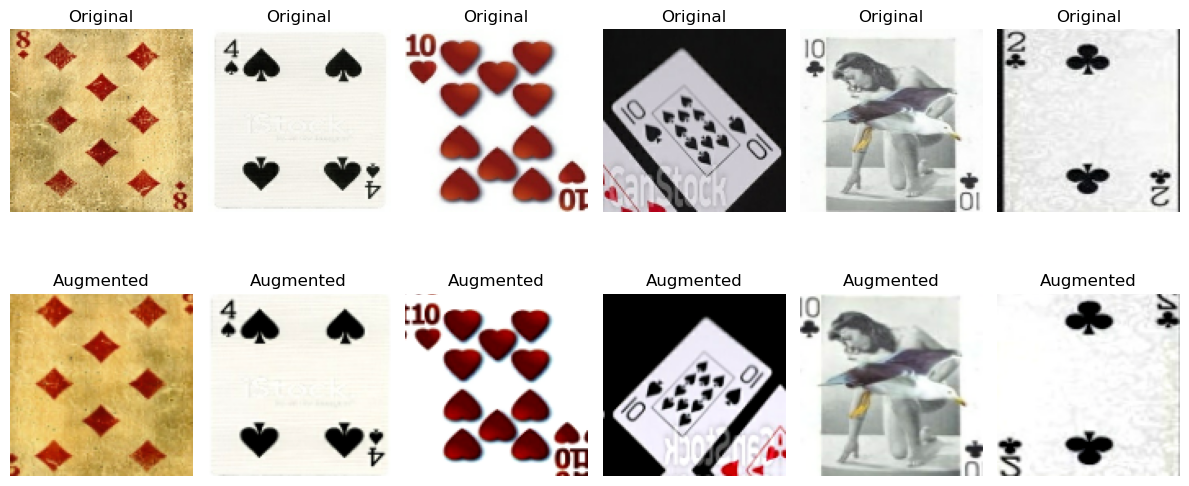

In [11]:
images, _ = next(iter(train_ds.take(1)))
augmented_images = data_augmentation(images)

# Plot original and augmented images
plt.figure(figsize=(12, 6))
for i in range(6):
    # Original images in top row
    ax = plt.subplot(2, 6, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title("Original")
    plt.axis("off")

    # Augmented images in bottom row
    ax = plt.subplot(2, 6, i + 7)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.title("Augmented")
    plt.axis("off")

plt.tight_layout()
plt.show()

# Tensorflow warnings don't worry about them. Caused by data augmentation

In [12]:
# Augment only the training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Helper functions for model visualization

# Plot Training and Validation Accuracy/Loss and test model accuracy against test dataset
def plot_history(model, history):
    # Plot Training and Validation Accuracy/Loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    test_loss, test_accuracy = model.evaluate(test_ds)
    print(f"Test accuracy: {test_accuracy:.4f}")
    print(f"Test loss: {test_loss:.4f}")



# Helper function to visualize predictions

# Displays n predictions from the test dataset and each class predicted probability
def test_model_visualization(n, model, dataset):

    n = n  # number of predictions to display

    # Get a batch of test images and labels
    images, labels = next(iter(dataset.take(1)))

    # Make predictions
    predictions = model.predict(images)

    # Get class names
    class_names = [
        'ace of clubs', 'ace of diamonds', 'ace of hearts', 'ace of spades',
        'eight of clubs', 'eight of diamonds', 'eight of hearts', 'eight of spades',
        'five of clubs', 'five of diamonds', 'five of hearts', 'five of spades',
        'four of clubs', 'four of diamonds', 'four of hearts', 'four of spades',
        'jack of clubs', 'jack of diamonds', 'jack of hearts', 'jack of spades',
        'joker',
        'king of clubs', 'king of diamonds', 'king of hearts', 'king of spades',
        'nine of clubs', 'nine of diamonds', 'nine of hearts', 'nine of spades',
        'queen of clubs', 'queen of diamonds', 'queen of hearts', 'queen of spades',
        'seven of clubs', 'seven of diamonds', 'seven of hearts', 'seven of spades',
        'six of clubs', 'six of diamonds', 'six of hearts', 'six of spades',
        'ten of clubs', 'ten of diamonds', 'ten of hearts', 'ten of spades',
        'three of clubs', 'three of diamonds', 'three of hearts', 'three of spades',
        'two of clubs', 'two of diamonds', 'two of hearts', 'two of spades'
    ]

    # Loop through n predictions
    for i in range(n):
        # Select the image and its corresponding true and predicted label
        image = images[i]
        true_label = np.argmax(labels[i])
        predicted_label = np.argmax(predictions[i])

        class_probabilities = predictions[i]

        fig, ax = plt.subplots(1, 2, figsize=(15, 6))

        ax[0].imshow(image.numpy().astype("uint8"))
        ax[0].set_title(f"True: {class_names[true_label]}")
        ax[0].axis('off')

        ax[1].barh(class_names, class_probabilities)
        ax[1].set_xlabel('Probability')
        ax[1].set_title(f"Predicted: {class_names[predicted_label]}")

        plt.tight_layout()
        plt.show()

# Tensorflow warnings don't worry about them. Caused by data augmentation

In [13]:
# Defining callbacks

# Learning rate scheduler
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=10,
    min_lr=1e-6,
    verbose=1
)

# Early stopping with longer patience
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [14]:
# Best performance model

def residual_block(x, filters):
    """Creates a residual block with two Conv2D layers."""
    residual = x  # Save input for skip connection
    x = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Add()([x, residual])
    x = tf.keras.layers.Activation('relu')(x)
    return x

# Define the input layer
inputs = tf.keras.layers.Input(shape=(112, 112, 3))

# Rescale pixel values
x = tf.keras.layers.Rescaling(1./255)(inputs)

# Initial Conv Block
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)

# Block 1
x = residual_block(x, 64)
x = residual_block(x, 64)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

# Block 2
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = residual_block(x, 128)
x = residual_block(x, 128)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

# Block 3
x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = residual_block(x, 256)
x = residual_block(x, 256)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

# Last Layers
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(53, activation='softmax')(x)

best_performance_model = tf.keras.Model(inputs=inputs, outputs=outputs)

best_performance_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])

best_performance_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 112, 112, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 112, 112, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  1792        ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

Epoch 1/50
239/239 [==============================] - 53s 195ms/step - loss: 3.9407 - accuracy: 0.0605 - val_loss: 3.4906 - val_accuracy: 0.0755 - lr: 0.0010
Epoch 2/50
239/239 [==============================] - 46s 192ms/step - loss: 3.2672 - accuracy: 0.1019 - val_loss: 3.1767 - val_accuracy: 0.1019 - lr: 0.0010
Epoch 3/50
239/239 [==============================] - 46s 194ms/step - loss: 2.8912 - accuracy: 0.1668 - val_loss: 2.6910 - val_accuracy: 0.2302 - lr: 0.0010
Epoch 4/50
239/239 [==============================] - 46s 194ms/step - loss: 2.5310 - accuracy: 0.2374 - val_loss: 2.3958 - val_accuracy: 0.2566 - lr: 0.0010
Epoch 5/50
239/239 [==============================] - 47s 194ms/step - loss: 2.2313 - accuracy: 0.3152 - val_loss: 1.7384 - val_accuracy: 0.4453 - lr: 0.0010
Epoch 6/50
239/239 [==============================] - 47s 194ms/step - loss: 1.9260 - accuracy: 0.4128 - val_loss: 1.6888 - val_accuracy: 0.4792 - lr: 0.0010
Epoch 7/50
239/239 [==============================] 

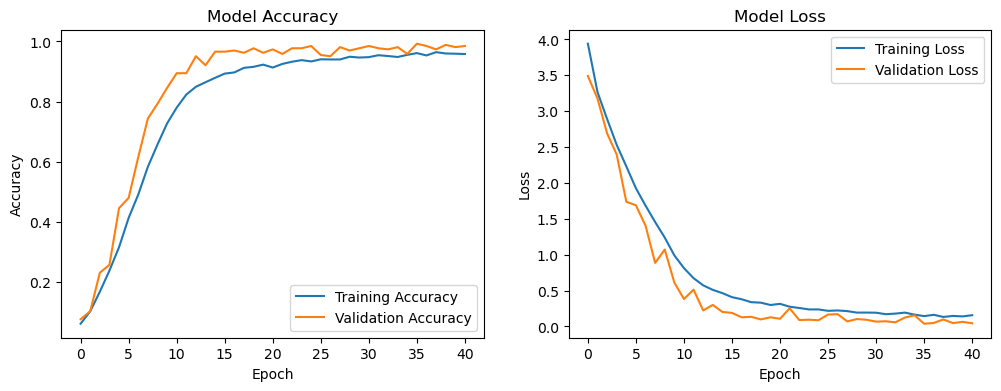

9/9 [==============================] - 0s 41ms/step - loss: 0.1036 - accuracy: 0.9660
Test accuracy: 0.9660
Test loss: 0.1036


In [15]:
# Train model and visualize predictions
history = best_performance_model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=50,  # Increase epochs ? only if model does not early stop, then it shows there was still room for improvement
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

plot_history(best_performance_model, history)

In [27]:
# Accuracy and loss on test dataset

test_loss, test_accuracy = best_performance_model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

9/9 [==============================] - 1s 40ms/step - loss: 0.1036 - accuracy: 0.9660
Test accuracy: 0.9660
Test loss: 0.1036


1/1 [==============================] - 0s 293ms/step


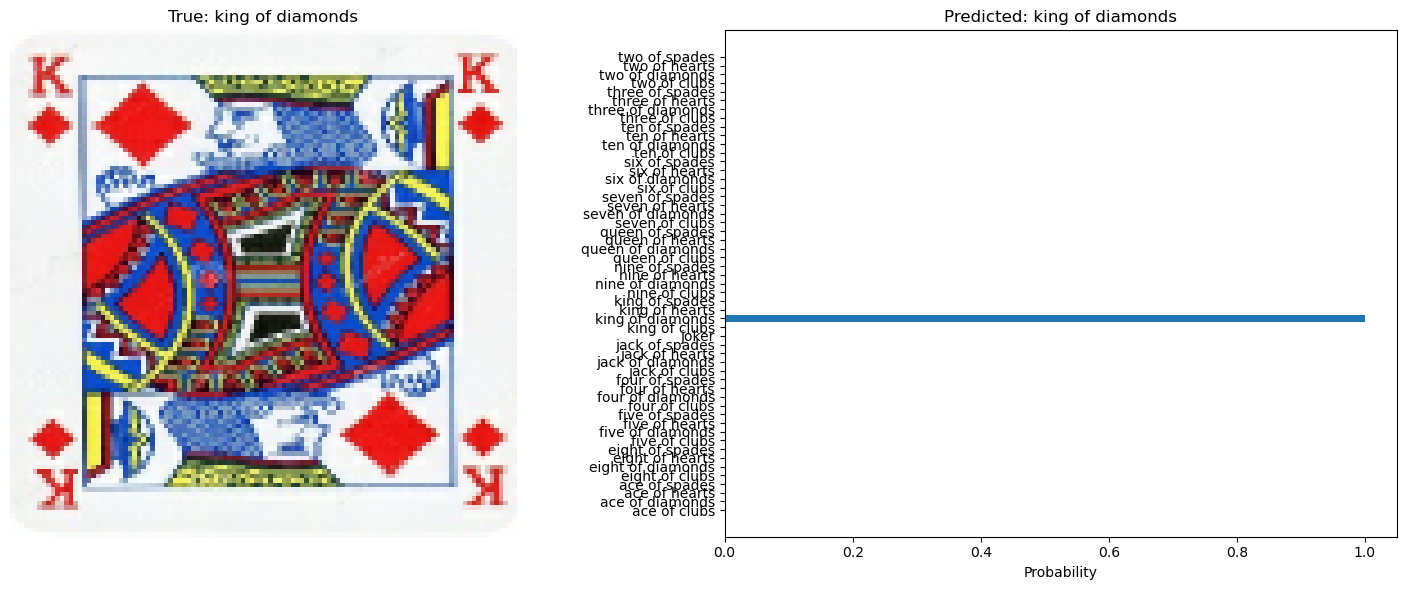

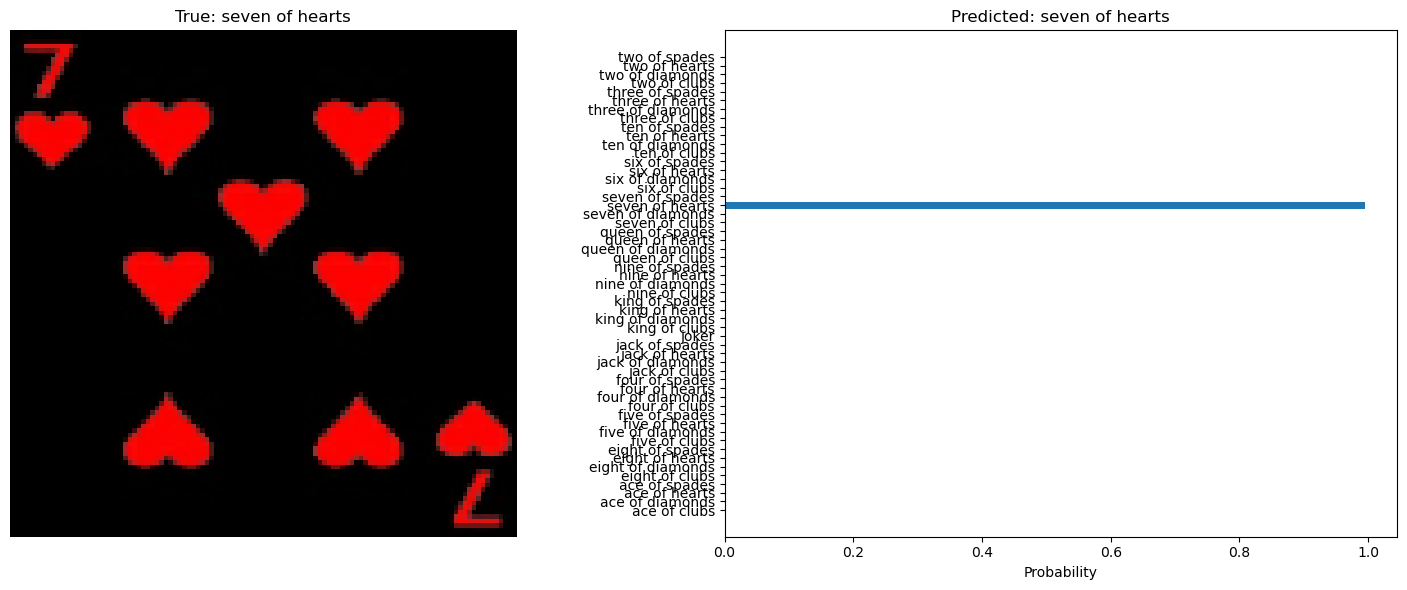

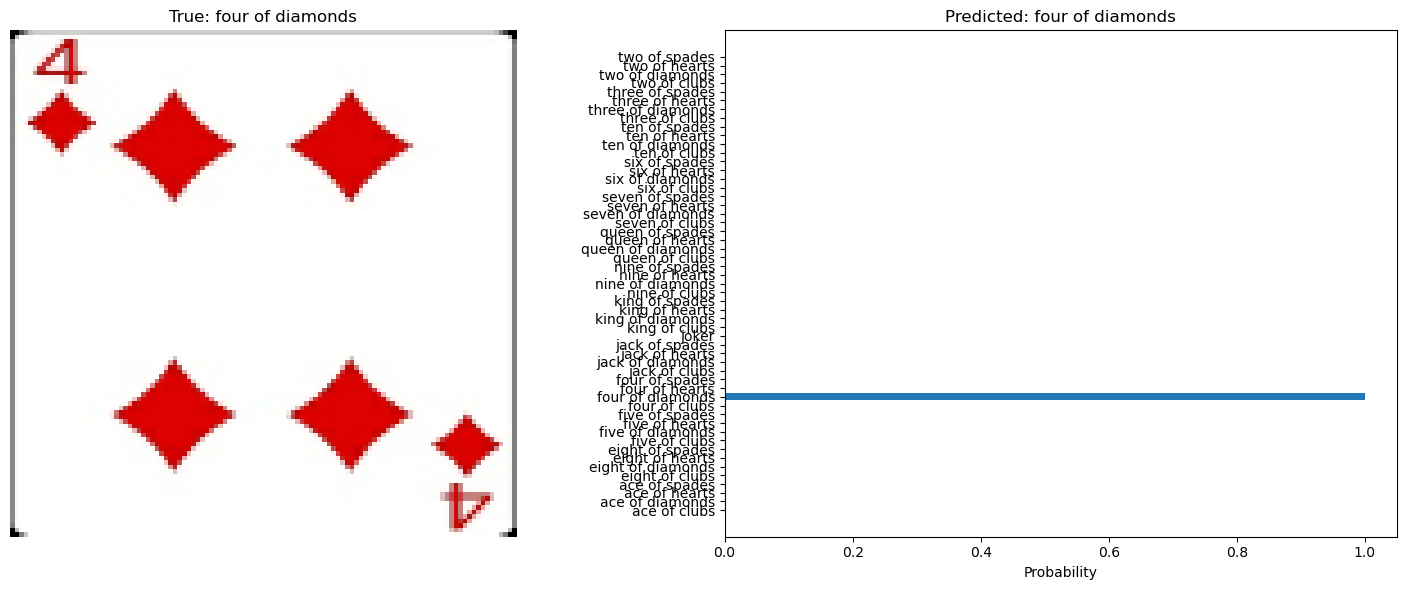

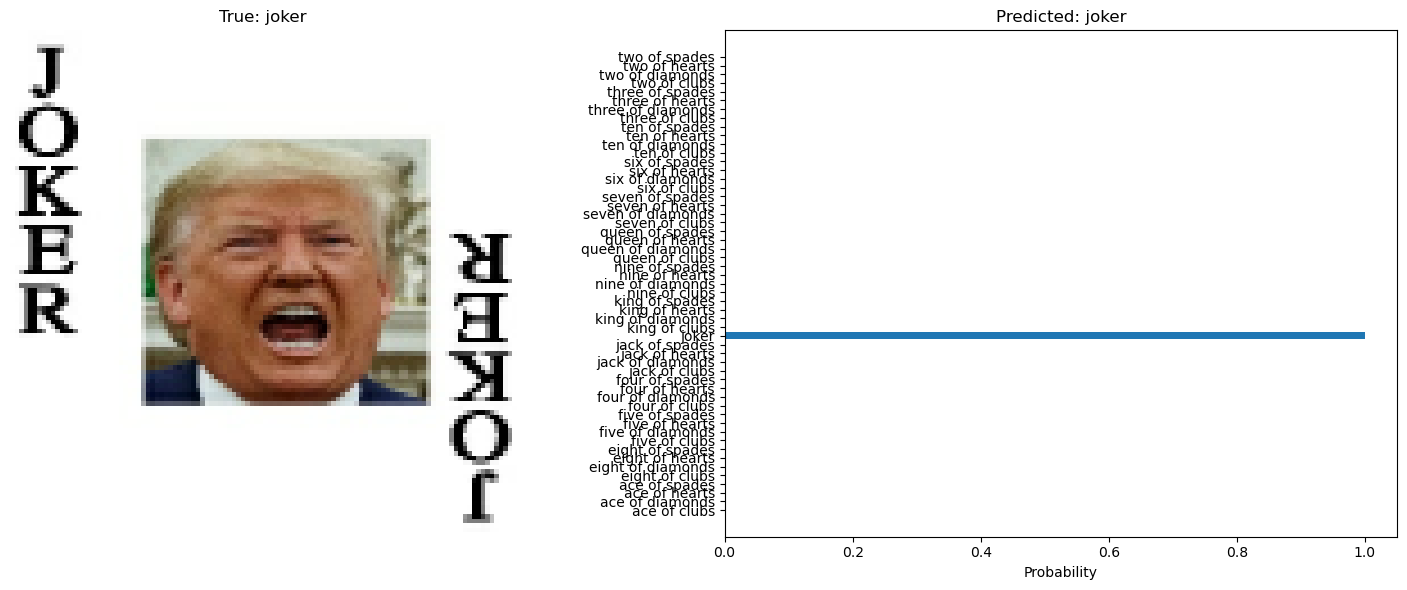

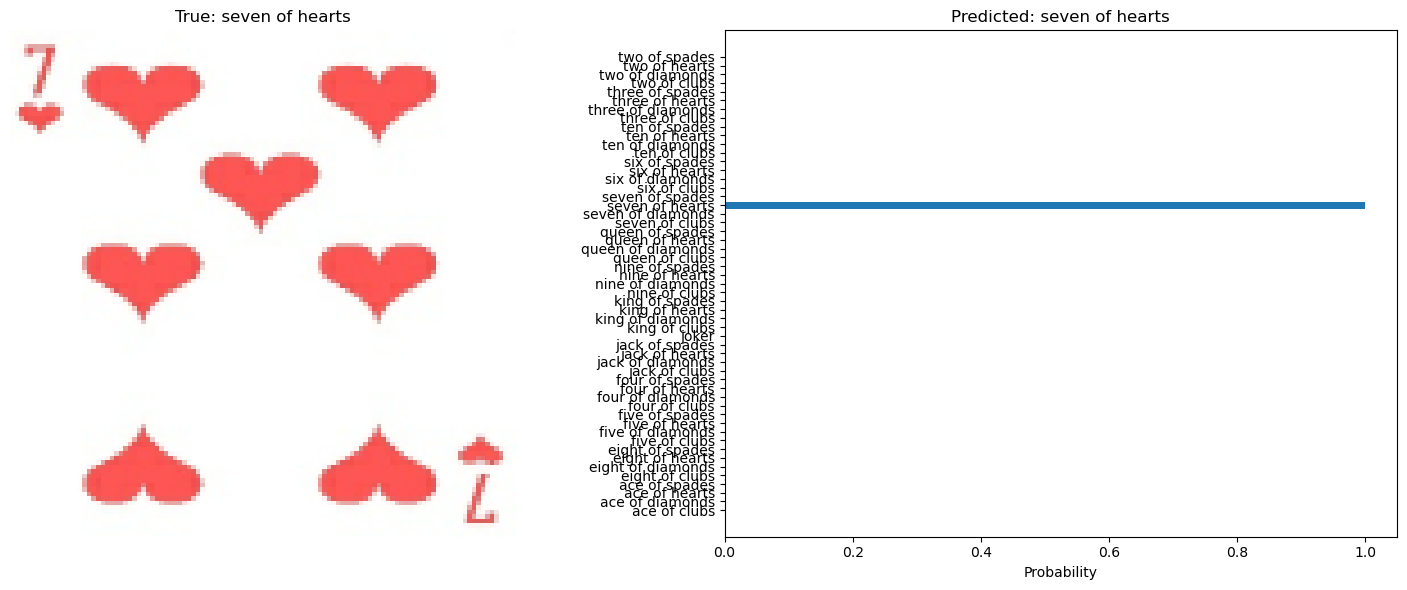

In [16]:
# Save best performance model and visualize predictions
number_of_predictions = 5
best_performance_model.save("best_performance_model.keras")  # Saves architecture + weights in one file
test_model_visualization(number_of_predictions, best_performance_model, test_ds)

In [17]:
# Size optimized model

def efficient_residual_block(x, filters):
    residual = x
    x = tf.keras.layers.SeparableConv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.SeparableConv2D(filters, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Add()([x, residual])
    x = tf.keras.layers.Activation('relu')(x)
    return x

# Define the input layer
inputs = tf.keras.layers.Input(shape=(112, 112, 3))

# Rescale pixel values
x = tf.keras.layers.Rescaling(1./255)(inputs)

# Initial Conv Block
x = tf.keras.layers.SeparableConv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)

# Block 1 (Reduce filters)
x = efficient_residual_block(x, 32)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

# Block 2
x = tf.keras.layers.SeparableConv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = efficient_residual_block(x, 64)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

# Block 3
x = tf.keras.layers.SeparableConv2D(128, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = efficient_residual_block(x, 128)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

# Last Layers
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.4)(x)  # Less aggressive dropout
outputs = tf.keras.layers.Dense(53, activation='softmax')(x)

size_optimized_model = tf.keras.Model(inputs=inputs, outputs=outputs)

size_optimized_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                             loss='categorical_crossentropy',
                             metrics=['accuracy'])

size_optimized_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 112, 112, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 112, 112, 3)  0           ['input_2[0][0]']                
                                                                                                  
 separable_conv2d (SeparableCon  (None, 112, 112, 32  155        ['rescaling_1[0][0]']            
 v2D)                           )                                                                 
                                                                                            

Epoch 1/100
239/239 [==============================] - 20s 80ms/step - loss: 2.9943 - accuracy: 0.1379 - val_loss: 2.6756 - val_accuracy: 0.1623 - lr: 0.0010
Epoch 2/100
239/239 [==============================] - 19s 80ms/step - loss: 2.7789 - accuracy: 0.1790 - val_loss: 2.3111 - val_accuracy: 0.2302 - lr: 0.0010
Epoch 3/100
239/239 [==============================] - 19s 78ms/step - loss: 2.6019 - accuracy: 0.2112 - val_loss: 2.4953 - val_accuracy: 0.2264 - lr: 0.0010
Epoch 4/100
239/239 [==============================] - 19s 78ms/step - loss: 2.4636 - accuracy: 0.2392 - val_loss: 2.1137 - val_accuracy: 0.2906 - lr: 0.0010
Epoch 5/100
239/239 [==============================] - 19s 77ms/step - loss: 2.3275 - accuracy: 0.2592 - val_loss: 2.1474 - val_accuracy: 0.2377 - lr: 0.0010
Epoch 6/100
239/239 [==============================] - 19s 78ms/step - loss: 2.2270 - accuracy: 0.2825 - val_loss: 1.8634 - val_accuracy: 0.3472 - lr: 0.0010
Epoch 7/100
239/239 [==============================]

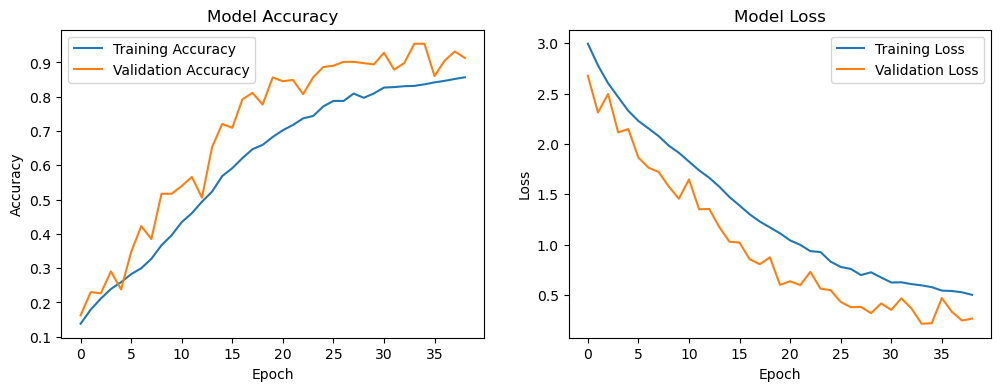

9/9 [==============================] - 0s 10ms/step - loss: 0.3717 - accuracy: 0.9057
Test accuracy: 0.9057
Test loss: 0.3717


In [23]:
# Train model
history = size_optimized_model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=100,  # Increase epochs
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

plot_history(size_optimized_model, history)

# Reason for 100 epochs is because we previously trained the best performance model for 50 epochs and encountered no early stopping.

In [28]:
# Accuracy and loss on test dataset

test_loss, test_accuracy = size_optimized_model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

9/9 [==============================] - 0s 10ms/step - loss: 0.3717 - accuracy: 0.9057
Test accuracy: 0.9057
Test loss: 0.3717


1/1 [==============================] - 0s 159ms/step


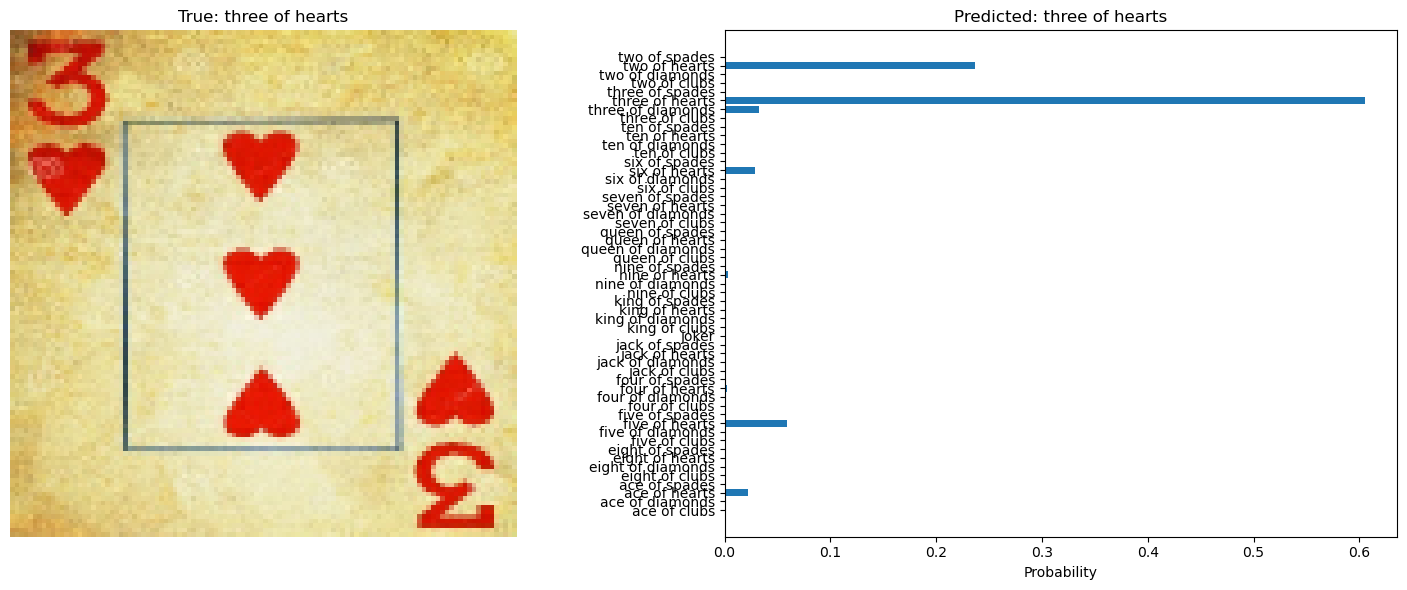

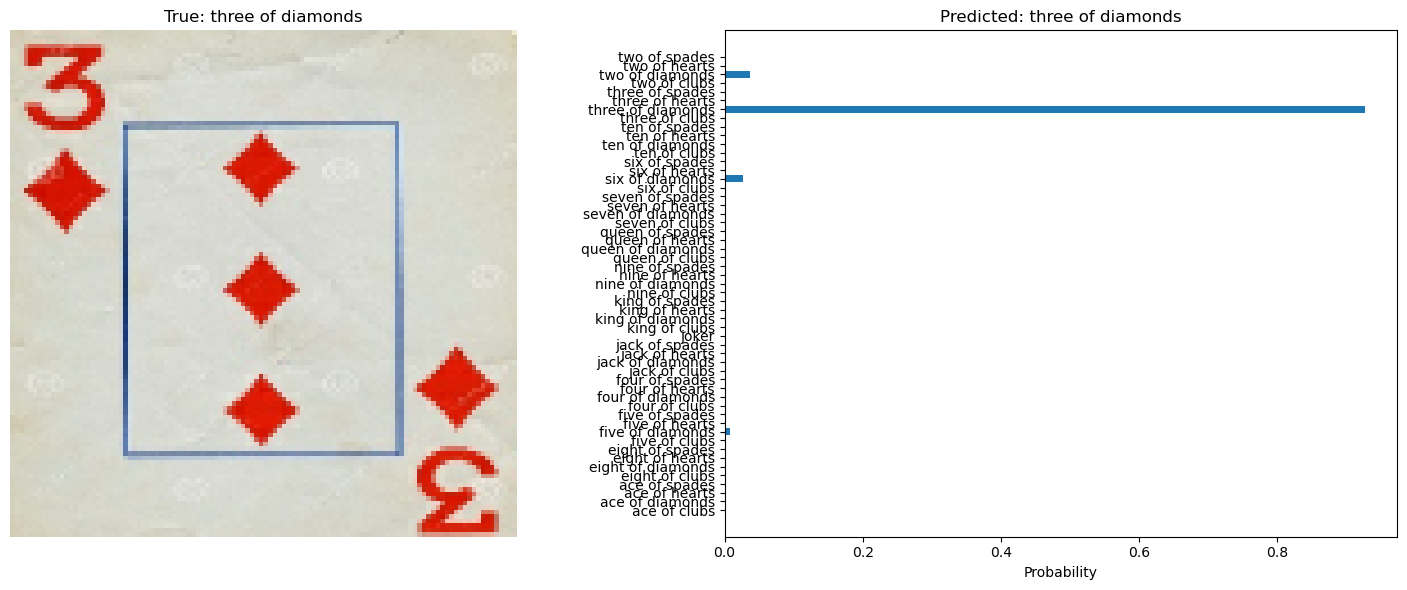

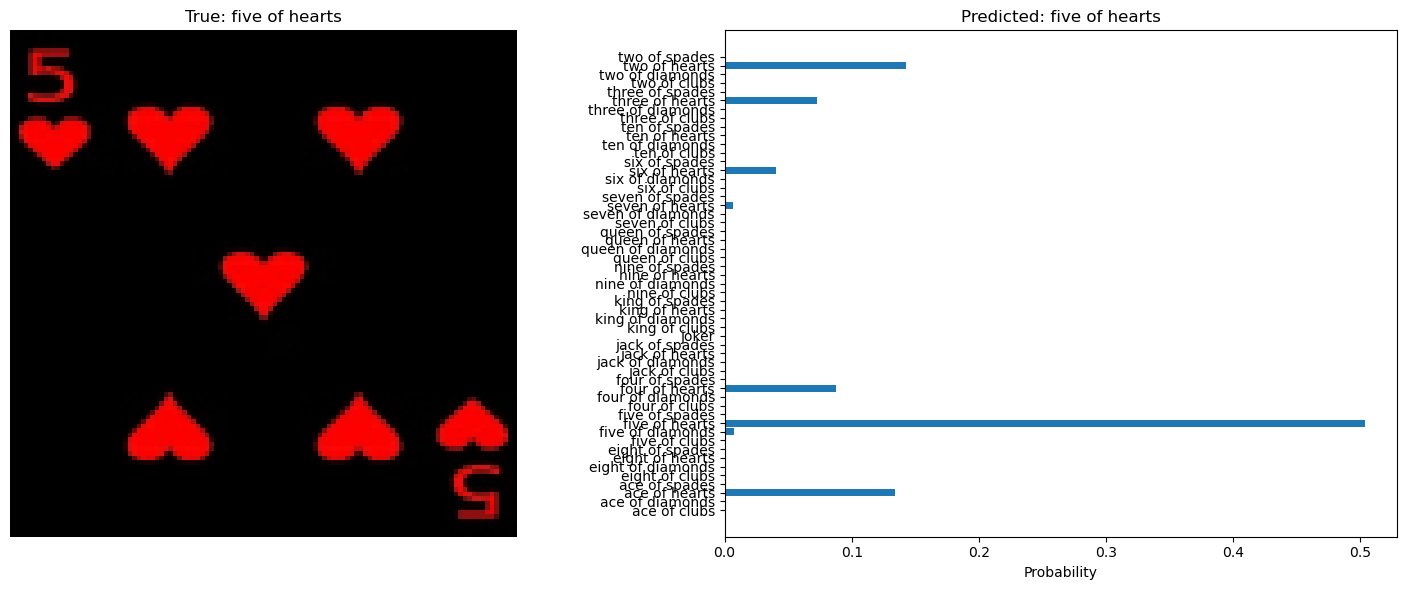

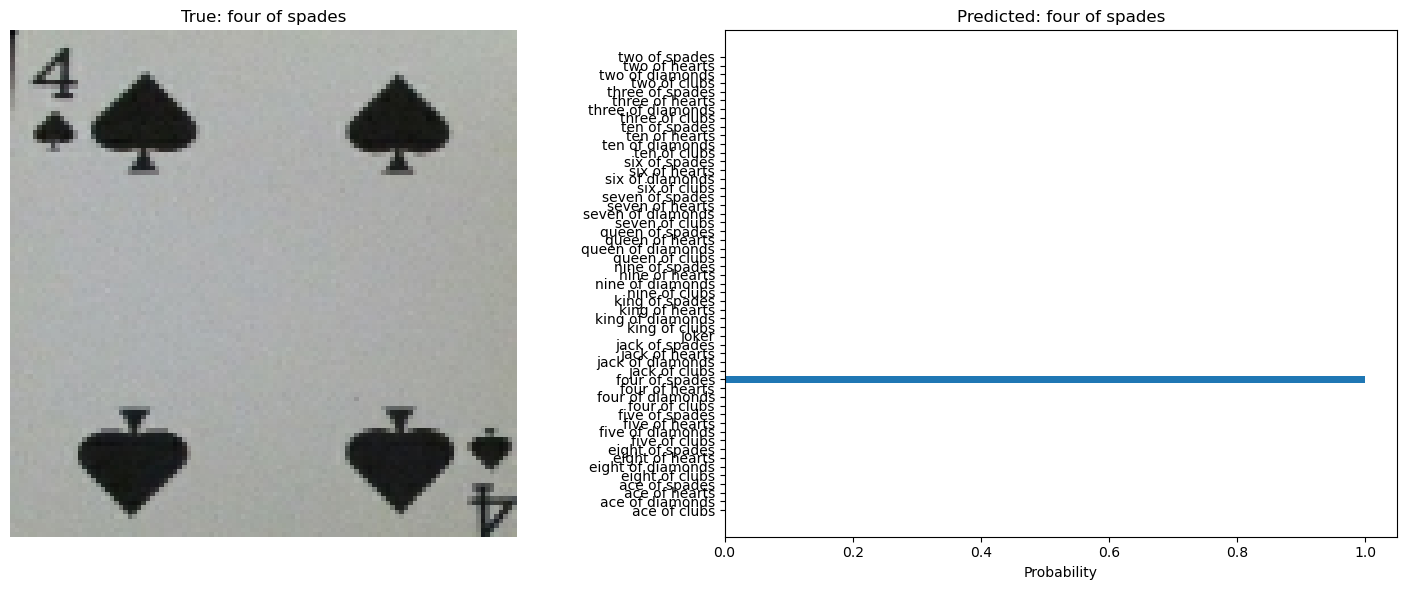

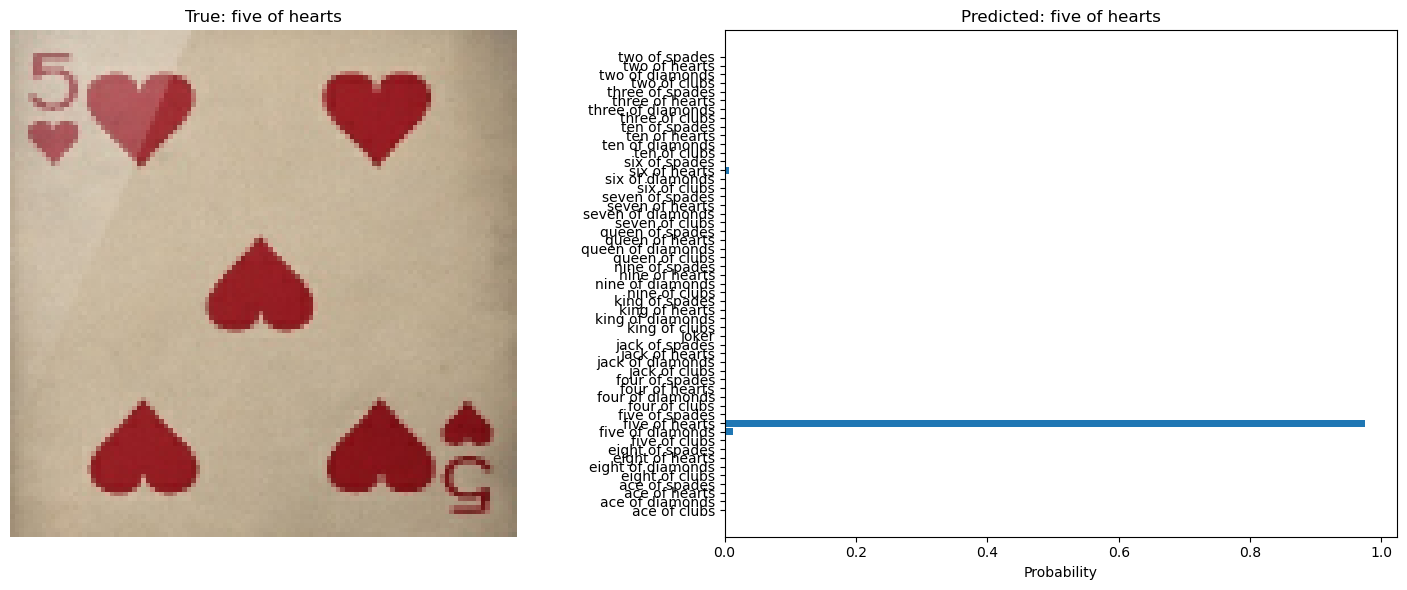

In [24]:
# Save size optimized model and visualize predictions
size_optimized_model.save("size_optimized_model.keras")
test_model_visualization(number_of_predictions, size_optimized_model, test_ds)